### Introduction
__Restricted Boltzmann Machine (RBM):__  RBMs are shallow neural nets that learn to reconstruct data by themselves in an unsupervised fashion.  

##### How does it work?
Simply, RBM takes the inputs and translates them to a set of numbers that represents them. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns.

##### What are the applications of RBM?
RBM is useful for Collaborative Filtering, dimensionality reduction, classification, regression, feature learning, topic modeling and even Deep Belief Networks.

##### RBM is a generative model. What is a generative model?
First, lets see what is different betwee discriminative and generative model:
Discriminative:Consider a classification problem in which we want to learn to distinguish between Sedan cars (y = 1) and SUV cars (y = 0), based on some features of an cars. Given a training set, an algorithm like logistic regression tries to find a straight line—that is, a decision boundary—that separates the suv and sedan. Generative: looking at cars, we can build a model of what Sedan cars look like. Then, looking at SUVs, we can build a separate model of what SUV cars look like. Finally, to classify a new car, we can match the new car against the Sedan model, and match it against the SUV model, to see whether the new car looks more like the SUV or Sedan.

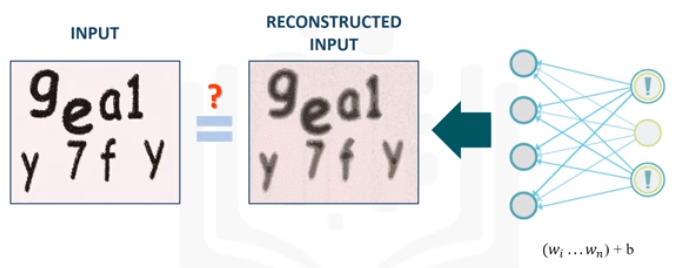

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_datamnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Loading data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### RBM layers

An RBM has two layers. The first layer of the RBM is called the __visible__ (or input layer). MNIST images have 784 pixels, so the visible layer must have 784 input nodes. 
The second layer is the __hidden__ layer, which possesses i neurons in our case. Each hidden unit has a binary state, which we’ll call it __si__, and turns either on or off (i.e., si = 1 or si = 0) with a probability that is a logistic function of the inputs it receives from the other j visible units, called for example, p(si = 1). For our case, we'll use 512 nodes in the hidden layer, so i = 512.

In [6]:
# Initializing the weights & biases

# We will denote the bias as “vb” for the visible units. The vb is shared among all visible units.
# We will denote the bias as “hb” for the hidden units. The hb is shared among all visible units.

vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [512])

W = tf.placeholder("float", [784, 512])

### RBM has two phases: 1) Forward Pass, and 2) Backward Pass or Reconstruction:
##### Phase 1) Forward pass:

Processing happens in each node in the hidden layer. That is, input data from all visible nodes are being passed to all hidden nodes. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer). At the hidden layer's nodes, X is multiplied by a W and added to h_bias. The result of those two operations is fed into the sigmoid function, which produces the node’s output/state. As a result, one output is produced for each hidden node. So, for each row in the training set, a tensor of probabilities is generated, which in our case it is of size [1x512], and totally 55000 vectors (h0=[55000x512]).
Then, we take the tensor of probabilities (as from a sigmoidal activation) and make samples from all the distributions, h0. That is, we sample the activation vector from the probability distribution of hidden layer values. Samples are used to estimate the negative phase gradient which will be explained later.

In [7]:
X = tf.placeholder("float", [None, 784])
_h0= tf.nn.sigmoid(tf.matmul(X, W) + hb)  #probabilities of the hidden units
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #sample_h_given_X

In [10]:
# Simple example to understand the kind of sampling we used in the above step

with  tf.Session() as sess:
    a= tf.constant([0.7, 0.1, 0.8, 0.2])
    print (sess.run(a))
    b=sess.run(tf.random_uniform(tf.shape(a)))
    print (b)
    print (sess.run(a-b))
    print (sess.run(tf.sign( a - b)))
    print (sess.run(tf.nn.relu(tf.sign( a - b))))

[ 0.69999999  0.1         0.80000001  0.2       ]
[ 0.16323555  0.84724128  0.22559845  0.58402693]
[ 0.53676444 -0.74724126  0.57440156 -0.38402694]
[ 1. -1.  1. -1.]
[ 1.  0.  1.  0.]


#### Phase 2) Backward Pass (Reconstruction): 
The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers.

So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h0) play the role of input. That is, h0 becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

In [11]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #sample_v_given_h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

#### What is objective function?
Goal: Maximize the likelihood of our data being drawn from that distribution
Calculate error:

In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n, e.g the error shows the difference between the data and its reconstruction.

Note: tf.reduce_mean computes the mean of elements across dimensions of a tensor.

In [12]:
err = tf.reduce_mean(tf.square(X - v1))

#### Optimization Algorithm 

When we derive, it give us 2 terms, called positive and negative gradient. These negative and positive phases reflect their effect on the probability density defined by the model. The positive one depends on observations (X), and the second one depends on only the model. 
 
The __Positive phase__ increases the probability of training data.  
The __Negative phase__ decreases the probability of samples generated by the model.  

The negative phase is hard to compute, so we use a method called __Contrastive Divergence (CD)__ to approximate it.  It is designed in such a way that at least the direction of the gradient estimate is somewhat accurate, even when the size is not (In real world models, more accurate techniques like CD-k or PCD are used to train RBMs). During the calculation of CD, we have to use __Gibbs sampling__ to sample from our model distribution.    

Contrastive Divergence is actually matrix of values that is computed and used to adjust values of the W matrix. Changing W incrementally leads to training of W values. Then on each step (epoch), W is updated to a new value W' through the equation below:
$W' = W + alpha * CD$ 

__ What is Alpha?__  
Here, alpha is some small step rate and is also known as the "learning rate".

__How can we calculate CD?__  
We can perform single-step Contrastive Divergence (CD-1) taking the following steps:

1. Take a training sample from X, compute the probabilities of the hidden units and sample a hidden activation vector h0 from this probability distribution.
 - $\_h0 = sigmoid(X \otimes W + hb)$
 - $h0 = sampleProb(h0)$
2. Compute the [outer product](https://en.wikipedia.org/wiki/Outer_product) of X and h0 and call this the positive gradient.
 - $w\_pos\_grad = X \otimes h0$  (Reconstruction in the first pass)  
3. From h, reconstruct v1, and then take a sample of the visible units, then resample the hidden activations h1 from this. (**Gibbs sampling step**)
 - $\_v1 = sigmoid(h0 \otimes transpose(W) + vb)$
 - $v1 = sample_prob(v1)$  (Sample v given h)
 - $h1 = sigmoid(v1 \otimes W + hb)$
4. Compute the outer product of v1 and h1 and call this the negative gradient.
 - $w\_neg\_grad = v1 \otimes h1$  (Reconstruction 1)
5. Now, CD equals the positive gradient minus the - negative gradient, CD is a matrix of size 784x512. 
 - $CD = (w\_pos\_grad - w\_neg\_grad) / datapoints$
6. Update the weight to be CD times some learning rate
 - $W' = W + alpha*CD$
7. At the end of the algorithm, the visible nodes will store the value of the sample.

#### What is sampling here (sampleProb)?
In forward pass: We randomly set the values of each hi to be 1 with probability $sigmoid(v \otimes W + hb)$.  
In reconstruction: We randomly set the values of each vi to be 1 with probability $ sigmoid(h \otimes transpose(W) + vb)$.

In [13]:
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(X), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [16]:
# Initialize the variables & start the session

cur_w = np.zeros([784, 512], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([512], np.float32)
prv_w = np.zeros([784, 512], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([512], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [17]:
# Error at the first run
sess.run(err, feed_dict={X: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48134524

##### To recall, the whole algorithm works as:  
- For each epoch, and for each batch do:
  - Compute CD as: 
     - For each data point in batch do:
        - w_pos_grad = 0, w_neg_grad= 0 (matrices)
        - Pass data point through net, calculating v (reconstruction) and h
        - update w_pos_grad = w_pos_grad + X$\otimes$h0
        - update w_neg_grad = w_neg_grad + v1$\otimes$h1
     - CD = average of pos_grad and neg_grad by dividing them by the amount of data points.
  - Update weights and biases W' = W + alpha * CD 
  - Calculate error
- Repeat for the next epoch until error is small or after some fixed number of epochs.

Epoch: 0 reconstruction error: 0.064514
Epoch: 1 reconstruction error: 0.054581
Epoch: 2 reconstruction error: 0.050129
Epoch: 3 reconstruction error: 0.048534
Epoch: 4 reconstruction error: 0.046915


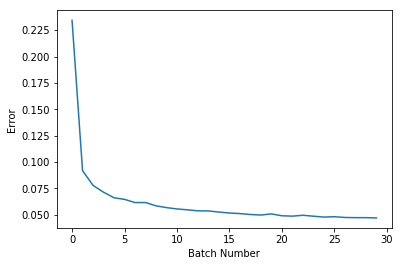

In [19]:
#Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={X: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print ('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

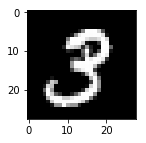

In [22]:
from utils import tile_raster_images
# Lets read an image & then reconstruct it
sample_case = trX[1:2]
img = Image.fromarray(tile_raster_images(X=sample_case, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')  #you can experiment different colormaps (Greys,winter,autumn)

In [23]:
# Passing the above image through the network
hh0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ X: sample_case, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

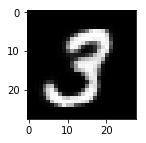

In [24]:
# Again plotting the reconstructed image
img = Image.fromarray(tile_raster_images(X=rec, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 